In [1]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.3 MB/s eta 0:00:00


In [2]:
pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.3 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=3d2500edf0ae690f575bb4576bd9bcbaad9026aa38820e7c2808ff08eb98430d
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [3]:
pip install levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 48.7 MB/s eta 0:00:00


In [4]:
from sentence_transformers import SentenceTransformer
from transformers import pipeline
import spacy
from numpy import dot
from numpy.linalg import norm
import re
import collections
from math import log2
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import Levenshtein
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
import nltk
import pandas as pd

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
class Utility:
    def __init__(self):
      self.nlp=spacy.load('en_core_web_sm')
      self.stopwords = self.nlp.Defaults.stop_words
      self.vectorizer = TfidfVectorizer(stop_words=list(self.stopwords))

    def remove_links(self,text):
      url_pattern = r"http\S+|www\S+"
      return re.sub(url_pattern, "", text)

    def to_lowercase(self,text):
        if isinstance(text, str):
            return text.lower()
        else:
            return text

    def remove_mentions_and_tags(self,text):
        text = re.sub(r'@\S*', '', text)
        return re.sub(r'#\S*', '', text)

    def reshape_topic_output(self,dictionary):
      output_dict={}
      for i in range(0,9):
        output_dict[dictionary['labels'][i]]=dictionary['scores'][i]
      return collections.OrderedDict(sorted(output_dict.items()))

    def kl_divergence(self,p, q):
      return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))

    def calculate_pos_tagging(self,text):
      return [token.pos_ for token in self.nlp(text)]

    def compute_tfidf_matrix(self,corpus):
      corpus=map(self.remove_links,corpus)
      corpus=list(map(self.remove_mentions_and_tags,corpus))
      res=self.vectorizer.fit_transform(corpus)
      feature_names=self.vectorizer.get_feature_names_out()
      return res,feature_names

    def add_row_to_dataframe(self,df, new_data):
      df.loc[len(df.index)] = new_data
      return df




In [8]:
class Matcher():
  def __init__(self):
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.similarity_model=SentenceTransformer('sentence-transformers/all-distilroberta-v1').to(self.device)
    self.topic_model=pipeline("zero-shot-classification",model="valhalla/distilbart-mnli-12-1",device=0)#device=0
    self.candidate_topic_labels=candidate_labels = ["Sports","Technology","Politics","Fashion","Health_Fitness","Travel","Business_Finance","Science_Education","Social_Issues"]
    self.utility=Utility()
    self.paraphrase_model=AutoModelForSequenceClassification.from_pretrained("Prompsit/paraphrase-bert-en").to(self.device)
    self.paraphrase_tokenizer=AutoTokenizer.from_pretrained("Prompsit/paraphrase-bert-en")
    self.entailment_model=pipeline("text-classification",model="geckos/bart-fined-tuned-on-entailment-classification",tokenizer="geckos/bart-fined-tuned-on-entailment-classification",return_all_scores=True,device=0)#device=0
    #self.vectorizer = TfidfVectorizer()
    self.subjectivity_model=pipeline(task="text-classification",model="cffl/bert-base-styleclassification-subjective-neutral",return_all_scores=True,device=0)#device=0

  def compute_similarity(self,text1,text2):
    couple=(text1,text2)
    embeddings = self.similarity_model.encode(couple)
    cos_sim = dot(embeddings[0], embeddings[1])/(norm(embeddings[0])*norm(embeddings[1]))
    return cos_sim

  def compute_topic_coherence(self,sentence1,sentence2):
    t1=self.utility.remove_mentions_and_tags(self.utility.remove_links(sentence1))
    t2=self.utility.remove_mentions_and_tags(self.utility.remove_links(sentence2))
    dist_t1=self.topic_model(t1, self.candidate_topic_labels)
    dist_t2=self.topic_model(t2, self.candidate_topic_labels)
    dist_t1=self.utility.reshape_topic_output(dist_t1)
    dist_t2=self.utility.reshape_topic_output(dist_t2)
    return self.utility.kl_divergence(list(dist_t1.values()),list(dist_t2.values()))

  def compute_paraphrase(self,sentence1,sentence2):
    input = self.paraphrase_tokenizer(sentence1,sentence2,return_tensors='pt').to(self.device)
    logits = self.paraphrase_model(**input).logits
    soft = torch.nn.Softmax(dim=1)
    result=soft(logits).tolist()[0]
    return result[1]

  def compute_entailment(self,sentence1,sentence2):
    desired_score=0
    full_text=" "
    if sentence1.endswith('.'):
      full_text=sentence1+" "+sentence2
    else:
      full_text=sentence1+". "+sentence2
    res=self.entailment_model(full_text)[0]
    for item in res:
      if item['label'] == "entailment":
        desired_score = item['score']
        break
    return desired_score


  def compute_positional_distance(self,sentence1,sentence2):
    return Levenshtein.distance(self.utility.calculate_pos_tagging(sentence1),self.utility.calculate_pos_tagging(sentence2))

  def compute_tfidf_similarity(self,sentence1,sentence2,vectorizer_):
    t1=self.utility.remove_mentions_and_tags(self.utility.remove_links(sentence1))
    t2=self.utility.remove_mentions_and_tags(self.utility.remove_links(sentence2))
    t1_vector = vectorizer_.transform([t1]).toarray()
    t2_vector = vectorizer_.transform([t2]).toarray()
    similarity = cosine_similarity(t1_vector, t2_vector)
    return similarity[0][0]


  #????????????????????????????????????????????????????
  def compute_subjectivity(self, sentence):
    res=self.subjectivity_model(sentence)
    if res[0][0]['label']=='SUBJECTIVE':
      return res[0][0]['score']
    else:
      return res[0][1]['score']


# **Prova**

In [9]:
#se erroe, rimuovere device=0 sopra
m=Matcher()

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [15]:
import json
# Load the JSON file into a dictionary
with open('similarity_sample0.json', 'r') as f:
    similarity = json.load(f)

In [16]:
source=" "
candidates=[]
for dir in similarity['0']:
  if dir=="statement":
    source=similarity['0'][dir]
  if dir=='related tweets':
    for x in similarity['0'][dir]:
      candidates.append(x[2])

In [17]:
corpus=[source]+candidates

In [18]:
u=Utility()

In [19]:
tfidf_matrix,f=u.compute_tfidf_matrix(corpus)
pd.DataFrame(tfidf_matrix.toarray(),columns=f)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


,10,13,14,188,1956,200,2001,2008,2009,21,...,wounded,xstrata,yahoo,ye,year,years,yellen,yen,york,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.038472,0.0,0.041805,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.318676,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


In [20]:
import nltk
nltk.download('punkt')  # Download the necessary data for sentence tokenization

from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [21]:
#source to list of senteces
sentences = sent_tokenize(source)

finals_source=[]
for sentence in sentences:
  finals_source.append(sentence)

finals_source=finals_source[:len(finals_source)-2]
finals_source[:2]

['The Federal Open Market Committee decided today to keep its target range for the federal funds rate at 0 to 1/4 percent.',
 'The Committee continues to anticipate that economic conditions are likely to warrant exceptionally low levels of the federal funds rate for some time.']

In [22]:
dict_tweet_index={}
dict_index_tweet={}
i=0
for tweet in candidates:
  dict_tweet_index[tweet]=i
  dict_index_tweet[i]=tweet
  i=i+1

dict_source_index={}
dict_index_source={}
i=0
for source_sent in finals_source:
  dict_source_index[source_sent]=i
  dict_index_source[i]=source_sent
  i=i+1

In [24]:
df = pd.DataFrame({'Ref':[],
                   'Similarity': [],
                    'Topic Coherence': [],
                    'Paraphrase': [],
                    'Entailement': [],
                    'Pos Distance': [],
                    'TFIDF': []})


for sent_S in finals_source:
  print(finals_source.index(sent_S),"/",len(finals_source))
  for sent_Tw in candidates:
    s=m.compute_similarity(sent_S,sent_Tw)
    t=m.compute_topic_coherence(sent_S,sent_Tw)
    p=m.compute_paraphrase(sent_S,sent_Tw)
    e=m.compute_entailment(sent_S,sent_Tw)
    d=m.compute_positional_distance(sent_S,sent_Tw)
    f=m.compute_tfidf_similarity(sent_S,sent_Tw,u.vectorizer)
    new_data = [(dict_source_index[sent_S],dict_tweet_index[sent_Tw]),s,t,p,e,d,f]
    df=u.add_row_to_dataframe(df, new_data)

0 / 15


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:948: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset

1 / 15


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentiall

2 / 15


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentiall

3 / 15


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentiall

4 / 15


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentiall

5 / 15


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentiall

6 / 15


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentiall

7 / 15


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentiall

8 / 15


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentiall

9 / 15


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentiall

10 / 15


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentiall

11 / 15


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentiall

12 / 15


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentiall

13 / 15


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentiall

14 / 15


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentiall

In [26]:
df

,Ref,Similarity,Topic Coherence,Paraphrase,Entailement,Pos Distance,TFIDF
0,"(0, 0)",0.189727,0.365182,0.006243,0.014161,15,0.000000
1,"(0, 1)",0.233661,0.059617,0.280791,0.008199,20,0.000000
2,"(0, 2)",0.472772,0.053409,0.285607,0.037565,20,0.108065
3,"(0, 3)",0.294187,0.096504,0.017049,0.003332,16,0.000000
4,"(0, 4)",0.194575,0.073112,0.009909,0.007087,20,0.000000
...,...,...,...,...,...,...,...
1750,"(14, 112)",0.041760,0.153963,0.002696,0.000712,48,0.000000
1751,"(14, 113)",0.083370,0.071945,0.012276,0.008072,50,0.000000
1752,"(14, 114)",-0.028562,0.207223,0.003945,0.012266,40,0.000000
1753,"(14, 115)",0.012558,0.300544,0.002586,0.026094,50,0.000000


In [25]:
df.to_csv('output_model.csv', index=False)

In [ ]:
sour=df.iloc[557]['Ref'][0]
tweet=df.iloc[557]['Ref'][1]
dict_index_tweet[tweet],dict_index_source[sour]

('Deep gloom marks Davos opening: Deep gloom hung in the mountain air around Davos in the opening session of the W.. http://tinyurl.com/dmv87j',
 'Furthermore, global demand appears to be slowing significantly.')

# **Little test entailment model**

In [27]:
pip install jsonlines

In [28]:

import jsonlines

filename = 'multinli_1.0_dev_matched.jsonl'

dataset=[]
with jsonlines.open(filename, 'r') as reader:
    for json_data in reader:
        row={}
        row['sentence1']=json_data['sentence1']
        row['sentence2']=json_data['sentence2']
        row['label']=json_data['gold_label']
        dataset.append(row)


In [29]:
df = pd.DataFrame(dataset)
df

,sentence1,sentence2,label
0,The new rights are nice enough,Everyone really likes the newest benefits,neutral
1,This site includes a list of all award winners...,The Government Executive articles housed on th...,contradiction
2,uh i don't know i i have mixed emotions about ...,"I like him for the most part, but would still ...",entailment
3,yeah i i think my favorite restaurant is alway...,My favorite restaurants are always at least a ...,contradiction
4,i don't know um do you do a lot of camping,I know exactly.,contradiction
...,...,...,...
9995,"Since 1998, LSC has initiated and overseen sig...",LSC has been focusing on improving it's state ...,neutral
9996,Eighty percent of pagers in the United States ...,Pagers in the United States were unaffected by...,contradiction
9997,"Finally, the FDA will conduct workshops, issue...",The FDA is set to conduct workshops.,entailment
9998,Cirque du Soleil's The latest from the acclaim...,Cirque du Soleil is an international troupe.,entailment


In [31]:
#classifier=pipeline("text-classification",model="yoshitomo-matsubara/bert-base-uncased-rte",tokenizer="yoshitomo-matsubara/bert-base-uncased-rte")
classifier=pipeline("text-classification",model="geckos/bart-fined-tuned-on-entailment-classification",tokenizer="geckos/bart-fined-tuned-on-entailment-classification",device=0)
giusti=0
sbagliati=0
for row in df.iterrows():
  print(row[0])
  y_pred=classifier(row[1]['sentence1']+". "+row[1]['sentence2'])[0]['label']
  y_true=row[1]['label']
  if y_pred==y_true:
    giusti=giusti+1
  else:
    sbagliati=sbagliati+1

0
1
2
3
4
5
6
7
8
9
10
11
12
13


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Output streaming troncato alle ultime 5000 righe.
5000
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189


In [32]:
giusti/(giusti+sbagliati)

0.8688

In [3]:
import pandas as pd
df=pd.read_csv("output_model.csv")
df

,Ref,Similarity,Topic Coherence,Paraphrase,Entailement,Pos Distance,TFIDF
0,"(0, 0)",0.189727,0.365182,0.006243,0.014161,15,0.000000
1,"(0, 1)",0.233661,0.059617,0.280791,0.008199,20,0.000000
2,"(0, 2)",0.472772,0.053409,0.285607,0.037565,20,0.108065
3,"(0, 3)",0.294187,0.096504,0.017049,0.003332,16,0.000000
4,"(0, 4)",0.194575,0.073112,0.009909,0.007087,20,0.000000
...,...,...,...,...,...,...,...
1750,"(14, 112)",0.041760,0.153963,0.002696,0.000712,48,0.000000
1751,"(14, 113)",0.083370,0.071945,0.012276,0.008072,50,0.000000
1752,"(14, 114)",-0.028562,0.207223,0.003945,0.012266,40,0.000000
1753,"(14, 115)",0.012558,0.300544,0.002586,0.026094,50,0.000000


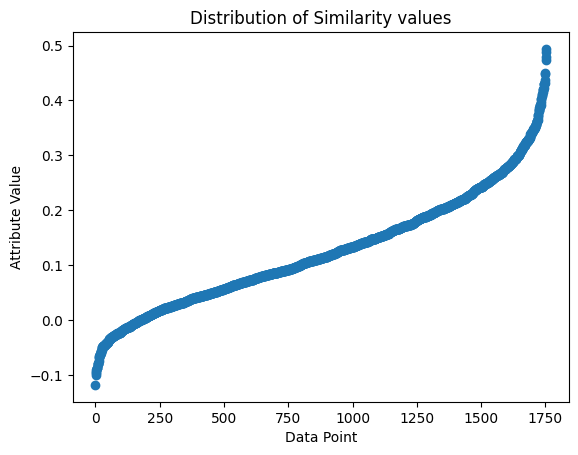

In [11]:
import matplotlib.pyplot as plt

# Assuming your attribute values are in a list called 'values'
plt.scatter(range(len(df["Similarity"])), df["Similarity"].sort_values())
plt.xlabel('Data Point')
plt.ylabel('Attribute Value')
plt.title('Distribution of Similarity values')
plt.show()

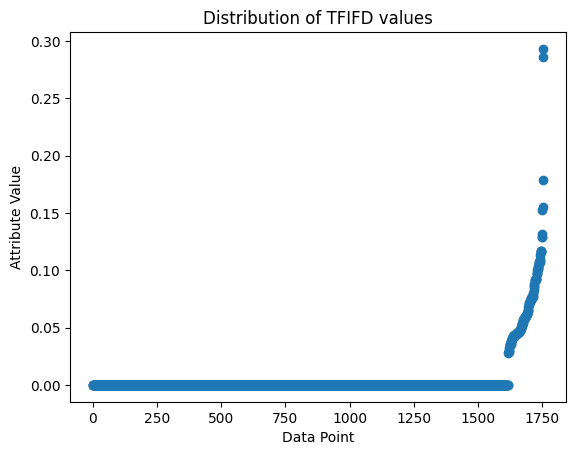

In [19]:
# Assuming your attribute values are in a list called 'values'
plt.scatter(range(len(df["TFIDF"])), df["TFIDF"].sort_values())
plt.xlabel('Data Point')
plt.ylabel('Attribute Value')
plt.title('Distribution of TFIFD values')
plt.show()

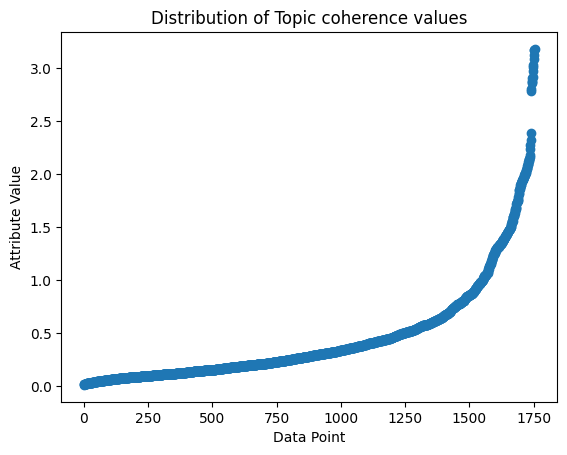

In [12]:
plt.scatter(range(len(df["Topic Coherence"])), df["Topic Coherence"].sort_values())
plt.xlabel('Data Point')
plt.ylabel('Attribute Value')
plt.title('Distribution of Topic coherence values')
plt.show()

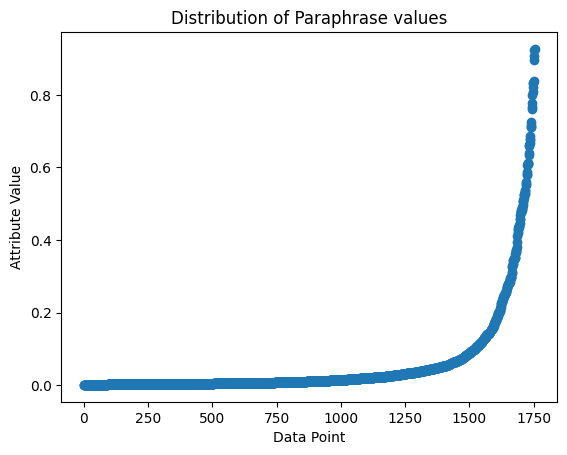

In [14]:
plt.scatter(range(len(df["Paraphrase"])), df["Paraphrase"].sort_values())
plt.xlabel('Data Point')
plt.ylabel('Attribute Value')
plt.title('Distribution of Paraphrase values')
plt.show()

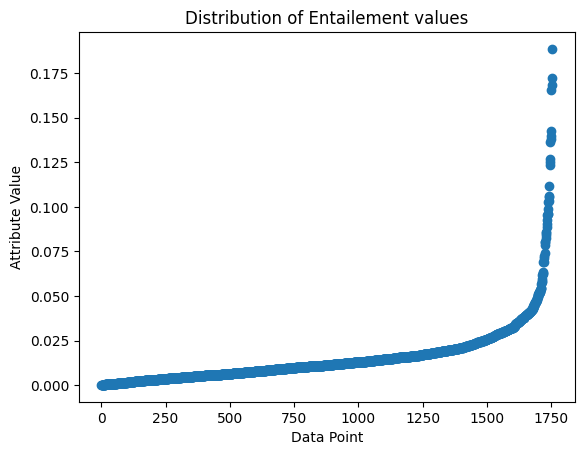

In [16]:
plt.scatter(range(len(df["Entailement"])), df["Entailement"].sort_values())
plt.xlabel('Data Point')
plt.ylabel('Attribute Value')
plt.title('Distribution of Entailement values')
plt.show()

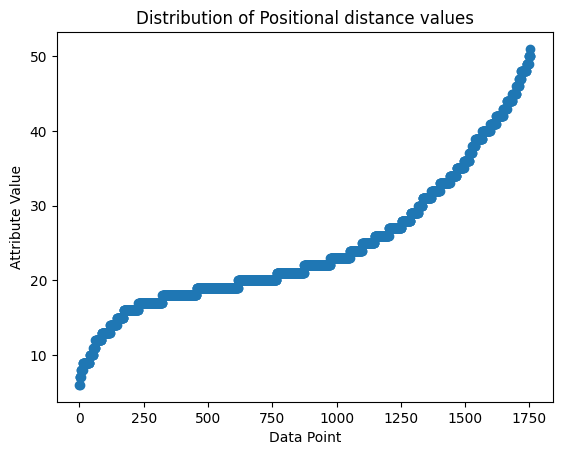

In [17]:
plt.scatter(range(len(df["Pos Distance"])), df["Pos Distance"].sort_values())
plt.xlabel('Data Point')
plt.ylabel('Attribute Value')
plt.title('Distribution of Positional distance values')
plt.show()

In [20]:
df[df['Entailement']>0.15]

,Ref,Similarity,Topic Coherence,Paraphrase,Entailement,Pos Distance,TFIDF
228,"(1, 111)",0.049672,0.143218,0.005713,0.165521,20,0.0
1393,"(11, 106)",0.016718,0.134046,0.002010,0.168145,45,0.0
1744,"(14, 106)",-0.034261,0.120529,0.002657,0.188554,51,0.0
1749,"(14, 111)",-0.027677,0.154413,0.005059,0.172127,44,0.0
